# Análisis Airbnb NYC — Q1 a Q8 (ELT Gold)

Este notebook carga datasets **GOLD** generados por el pipeline ELT y responde las preguntas de negocio.

**Requisitos**: haber corrido previamente el pipeline (`run.py`) para generar `data/gold/*.csv` y `data/staging/airbnb_listings_clean.csv`.

**Nota**: el notebook asume que se ejecuta desde la carpeta `notebooks/` del proyecto.

In [1]:
# %% [setup] - imports y rutas
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# El notebook vive en: <root>/notebooks/
# Subimos un nivel para llegar al root del proyecto
ROOT = Path('..').resolve()
GOLD = ROOT / 'data' / 'gold'
STAGING = ROOT / 'data' / 'staging'
DOCS = ROOT / 'docs'
DOCS.mkdir(parents=True, exist_ok=True)

# Cargar GOLD
avg_price_by_area = pd.read_csv(GOLD / 'avg_price_by_area.csv')
room_type_offer = pd.read_csv(GOLD / 'room_type_offer.csv')
room_type_rev = pd.read_csv(GOLD / 'room_type_revenue_proxy.csv')
top_hosts = pd.read_csv(GOLD / 'top_hosts.csv')
availability_by_district = pd.read_csv(GOLD / 'availability_by_district.csv')
reviews_monthly_by_ng = pd.read_csv(GOLD / 'reviews_monthly_by_ng.csv')

# Cargar STAGING para análisis adicionales
stg = pd.read_csv(STAGING / 'airbnb_listings_clean.csv', parse_dates=['last_review'])

avg_price_by_area.head(3), room_type_offer.head(3), room_type_rev.head(3)

(  neighbourhood_group   neighbourhood   avg_price
 0       Staten Island  Fort Wadsworth  799.000000
 1       Staten Island         Woodrow  700.000000
 2           Manhattan         Tribeca  355.367232,
          room_type  listings
 0  Entire home/apt     25407
 1     Private room     22319
 2      Shared room      1158,
          room_type  avg_revenue_proxy
 0  Entire home/apt         128.923883
 1     Private room          57.163333
 2      Shared room          42.443549)

## Q1 — ¿Cuál es el precio promedio de los alojamientos por barrio y distrito?

,neighbourhood_group,neighbourhood,avg_price
0,Staten Island,Fort Wadsworth,799.000000
1,Staten Island,Woodrow,700.000000
2,Manhattan,Tribeca,355.367232
3,Brooklyn,Sea Gate,316.142857
4,Manhattan,Flatiron District,298.725000
5,Staten Island,Prince's Bay,296.750000
6,Bronx,Riverdale,287.363636
7,Manhattan,NoHo,282.948718
8,Queens,Neponsit,274.666667
9,Manhattan,Midtown,270.519741


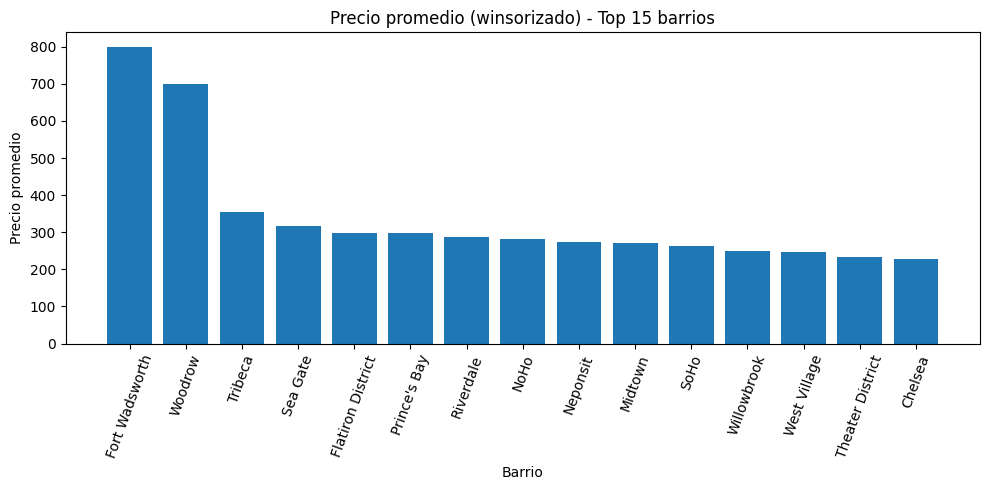

In [3]:
q1 = avg_price_by_area.sort_values('avg_price', ascending=False)
display(q1.head(20))
# Gráfico top 15 por barrio
q1_plot = q1.head(15)
plt.figure(figsize=(10,5))
plt.bar(q1_plot['neighbourhood'].astype(str), q1_plot['avg_price'])
plt.xticks(rotation=70)
plt.title('Precio promedio (winsorizado) - Top 15 barrios')
plt.xlabel('Barrio'); plt.ylabel('Precio promedio')
plt.tight_layout()
plt.savefig((DOCS / 'q1_top15_avg_price.png').as_posix())
plt.show()

## Q2 — ¿Qué tipo de habitación es el más ofrecido y cuál genera mayor revenue estimado?

,room_type,listings
0,Entire home/apt,25407
1,Private room,22319
2,Shared room,1158


,room_type,avg_revenue_proxy
0,Entire home/apt,128.923883
1,Private room,57.163333
2,Shared room,42.443549


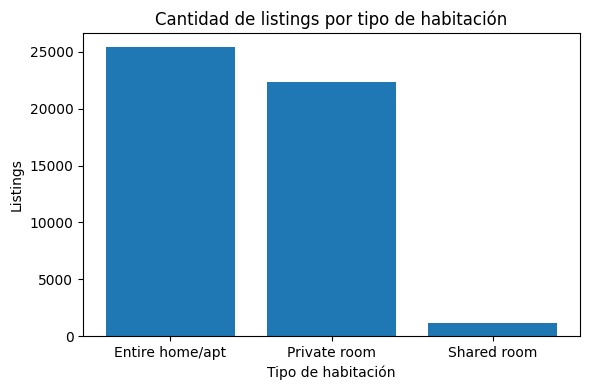

In [4]:
display(room_type_offer)
display(room_type_rev)

# Oferta por tipo de habitación
plt.figure(figsize=(6,4))
plt.bar(room_type_offer['room_type'].astype(str), room_type_offer['listings'])
plt.title('Cantidad de listings por tipo de habitación')
plt.xlabel('Tipo de habitación'); plt.ylabel('Listings')
plt.tight_layout()
plt.savefig((DOCS / 'q2_room_type_offer.png').as_posix())
plt.show()

## Q3 — ¿Cuáles son los anfitriones con más propiedades listadas y cómo varían sus precios?

In [5]:
top10_host_ids = top_hosts.sort_values('properties', ascending=False).head(10)['host_id'].tolist()
host_prices = stg[stg['host_id'].isin(top10_host_ids)][['host_id','host_name','price_winsor']].copy()

host_price_stats = host_prices.groupby(['host_id','host_name'])['price_winsor'].agg(
    listings='count',
    min='min',
    q25=lambda s: s.quantile(0.25),
    median='median',
    q75=lambda s: s.quantile(0.75),
    max='max',
    mean='mean'
).reset_index().sort_values('listings', ascending=False)

display(host_price_stats)

,host_id,host_name,listings,min,q25,median,q75,max,mean
9,219517861,Sonder (NYC),327,100,188.50,228.0,255.0,699,253.195719
6,107434423,Blueground,232,184,267.00,302.5,330.5,481,303.150862
4,30283594,Kara,121,109,219.00,239.0,269.0,799,271.000000
7,137358866,Kazuya,103,30,37.00,41.0,50.0,76,43.951456
2,16098958,Jeremy & Laura,96,117,163.75,180.0,250.0,550,208.958333
1,12243051,Sonder,96,125,182.00,209.5,239.0,377,213.031250
5,61391963,Corporate Housing,91,109,125.00,142.0,159.0,200,146.241758
3,22541573,Ken,87,149,189.50,210.0,245.0,289,215.436782
8,200380610,Pranjal,65,150,200.00,250.0,350.0,600,290.230769
0,7503643,Vida,52,129,129.00,149.0,159.0,199,149.192308


## Q4 — ¿Existen diferencias significativas en la disponibilidad anual entre barrios o tipos de alojamiento?

In [6]:
display(availability_by_district)

room_type_avail = stg.groupby('room_type', dropna=False)['availability_365'].median().reset_index().rename(
    columns={'availability_365':'median_availability_365'}
).sort_values('median_availability_365')
display(room_type_avail)

,neighbourhood_group,median_availability_365
0,Brooklyn,28.0
1,Manhattan,36.0
2,Queens,98.0
3,Bronx,148.0
4,Staten Island,219.0


,room_type,median_availability_365
0,Entire home/apt,42.0
1,Private room,45.0
2,Shared room,90.0


## Q5 — ¿Cómo evoluciona el número de reseñas por mes en los diferentes distritos?

,neighbourhood_group,year_month,reviews
0,Bronx,2014-08,1
1,Bronx,2014-09,11
2,Bronx,2015-01,1
3,Bronx,2015-02,2
4,Bronx,2015-08,1
5,Bronx,2015-10,2
6,Bronx,2015-12,11
7,Bronx,2016-01,1
8,Bronx,2016-03,11
9,Bronx,2016-05,2


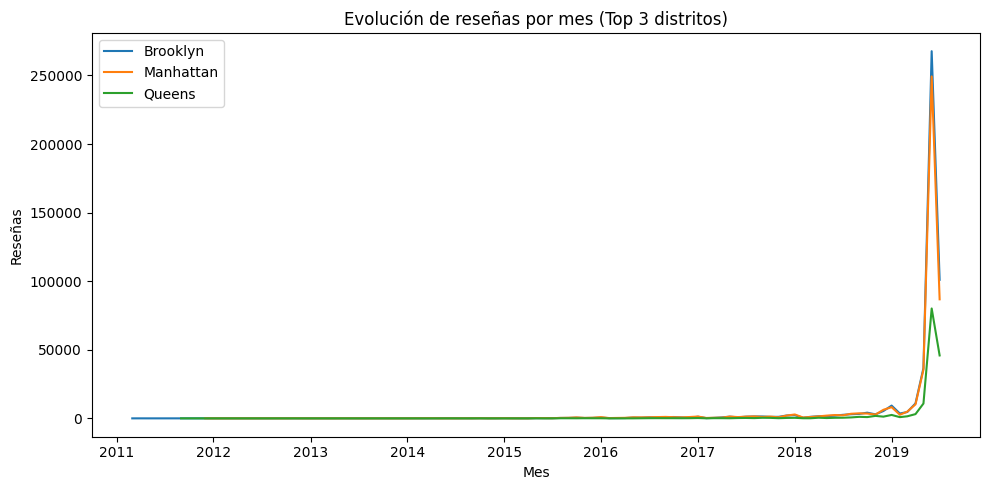

In [8]:
display(reviews_monthly_by_ng.head(30))

totals_by_ng = reviews_monthly_by_ng.groupby('neighbourhood_group')['reviews'].sum().sort_values(ascending=False).head(3).index.tolist()
plot_df = reviews_monthly_by_ng[reviews_monthly_by_ng['neighbourhood_group'].isin(totals_by_ng)].copy()
plot_df['year_month_dt'] = pd.to_datetime(plot_df['year_month'], errors='coerce')

plt.figure(figsize=(10,5))
for ng in totals_by_ng:
    sub = plot_df[plot_df['neighbourhood_group']==ng]
    plt.plot(sub['year_month_dt'], sub['reviews'], label=str(ng))
plt.legend()
plt.title('Evolución de reseñas por mes (Top 3 distritos)')
plt.xlabel('Mes'); plt.ylabel('Reseñas')
plt.tight_layout()
plt.savefig((DOCS / 'q5_reviews_timeline_top3.png').as_posix())
plt.show()

## Q6 — ¿Qué barrios tienen la mayor concentración de alojamientos activos?

In [10]:
top_neigh_by_count = stg.groupby('neighbourhood')['id'].count().reset_index().rename(columns={'id':'listings'}).sort_values('listings', ascending=False).head(20)
display(top_neigh_by_count)

,neighbourhood,listings
214,Williamsburg,3919
13,Bedford-Stuyvesant,3710
94,Harlem,2658
28,Bushwick,2462
202,Upper West Side,1971
95,Hell's Kitchen,1958
64,East Village,1853
201,Upper East Side,1798
51,Crown Heights,1564
127,Midtown,1545


## Q7 — ¿Cómo se distribuyen los precios y qué outliers existen?

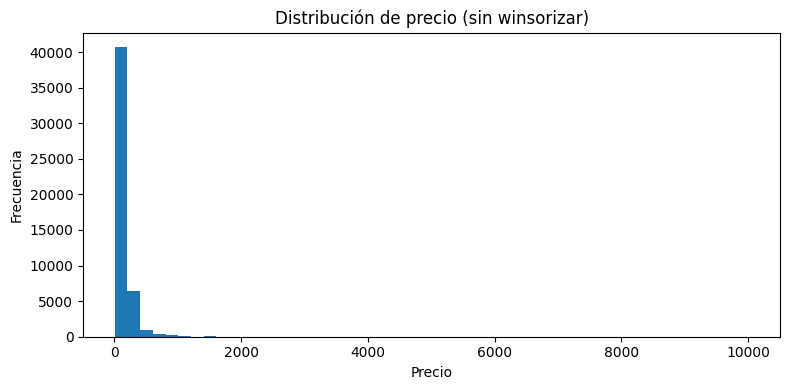

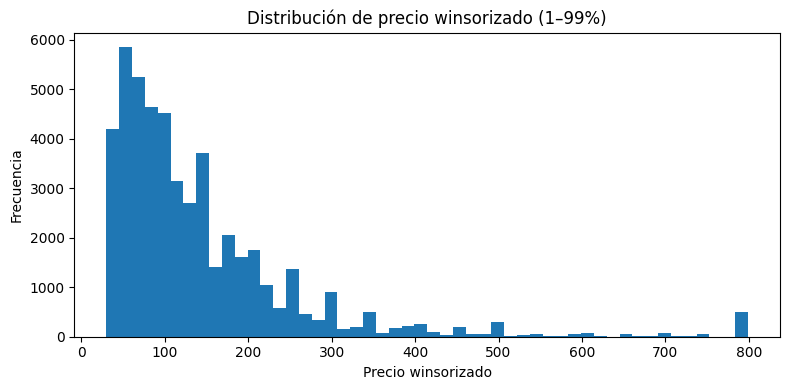

In [11]:
plt.figure(figsize=(8,4))
plt.hist(stg['price'].dropna(), bins=50)
plt.title('Distribución de precio (sin winsorizar)')
plt.xlabel('Precio'); plt.ylabel('Frecuencia')
plt.tight_layout()
plt.savefig((DOCS / 'q7_hist_price_raw.png').as_posix())
plt.show()

plt.figure(figsize=(8,4))
plt.hist(stg['price_winsor'].dropna(), bins=50)
plt.title('Distribución de precio winsorizado (1–99%)')
plt.xlabel('Precio winsorizado'); plt.ylabel('Frecuencia')
plt.tight_layout()
plt.savefig((DOCS / 'q7_hist_price_winsor.png').as_posix())
plt.show()

## Q8 — ¿Qué relación hay entre la disponibilidad anual y la cantidad de reseñas (proxy de ocupación)?

Correlación Pearson: 0.172


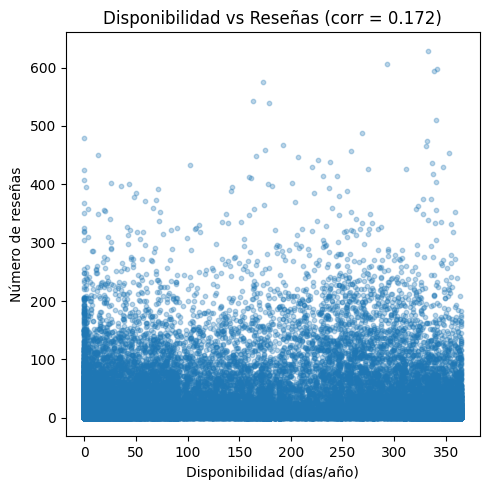

In [12]:
corr_df = stg[['availability_365','number_of_reviews']].dropna()
corr_value = corr_df['availability_365'].corr(corr_df['number_of_reviews'])
print(f'Correlación Pearson: {corr_value:.3f}')

plt.figure(figsize=(5,5))
plt.scatter(corr_df['availability_365'], corr_df['number_of_reviews'], s=10, alpha=0.3)
plt.title(f'Disponibilidad vs Reseñas (corr = {corr_value:.3f})')
plt.xlabel('Disponibilidad (días/año)'); plt.ylabel('Número de reseñas')
plt.tight_layout()
plt.savefig((DOCS / 'q8_scatter_availability_reviews.png').as_posix())
plt.show()